In [1]:
import sys, os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, optimizers, metrics, layers, Sequential, Model, Input, losses
from load_datasets import DataLoader
import time

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'  #防止训练过程中的kernel发生crash的情形

In [3]:
# 卷积层的生成器和鉴别器
def generator_network_dcgan(h, w, c, noise_dim=100):  # 输入噪声和标签，输出假图
    h_, w_ = h // 4, w // 4
    input_noise = Input(shape=(noise_dim,))  # (b,100)
    x = layers.Dense(h_ * w_ * 128)(input_noise)  #全连接层用于调整噪声的维度
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((h_, w_, 128))(x)  # (b,h/4,w/4,256)

    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)  # (b,h/2,w/2,128)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)  # (b,h,w,64)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(c, (3, 3), padding='same', activation='tanh')(x)  # (b,h,w,c)
    generator = Model(input_noise, x)
    return generator

In [4]:
def discriminator_network_dcgan(h, w, c):  # 输入图片和标签，输出待验证的值。输出1为真，0为假
    input_image = Input(shape=(h, w, c))  # (b,h,w,c)
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same')(input_image)  # (b,h/2,w/2,64)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)  
    x = layers.Dropout(0.3)(x)  #改进：在鉴别器的层之间添加dropout

    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)  # (b,h/4,w/4,128)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)  # (b,h/4,w/4,256)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)  # (b,h/4,w/4,512)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)  # (b,h/4*w/4*512)
    validity = layers.Dense(1, activation=None)(x)  # (b,1) 最后一层，flatten后全连接层

    discriminator = Model(input_image, validity)
    return discriminator

In [5]:
# WGAN-GP梯度控制函数
def gradient_penalty(discriminator, batch_x, fake_image):
    #梯度惩罚项计算函数
    batchsz = batch_x.shape[0]

    #每个样本均随机采样t,用于插值
    t = tf.random.uniform([batchsz,1,1,1])
    #自动扩展为x的形状:[b,1,1,1] => [b,h,w,c]
    t = tf.broadcast_to(t, batch_x.shape)
    #在真假图片之间作线性插值
    interplate = t * batch_x + (1-t) * fake_image
    #在梯度环境中计算 D 对插值样本的梯度
    with tf.GradientTape() as tape:
        tape.watch([interplate])
        d_interplate_logits = discriminator(interplate)

        grads = tape.gradient(d_interplate_logits, interplate)

        #计算每个样本的梯度的范数:[b,h,w,c] => [b,-1]
        grads = tf.reshape(grads, [grads.shape[0],-1])
        gp = tf.norm(grads,axis=1)
        #计算梯度惩罚项
        gp = tf.reduce_mean((gp-1.)**2)

    return gp

In [6]:
def save_image(fake_image, fake_label=None, fake_num=16, save_to=''):  # X为4维的带批次的图片
    ''' 
    用于保存图片的函数
    '''
    plt.figure()
    _, h, w, c = fake_image.shape  #设定生成假图的shape（128*128*3）
    if fake_num > 1:
        for i in range(fake_num):
            plt.subplot(4, 4, i + 1)  #训练过程中的迭代以4*4=16（一次保存16张图片）
            if c == 3:  # 如果是bgr则转为rgb（通道的转换）
                plt.imshow(cv.cvtColor(fake_image[i], cv.COLOR_BGR2RGB))  #对于一般格式与BGR格式都予以显示
            if c == 1:  # 如果是灰图则显示灰图
                plt.imshow(np.squeeze(fake_image[i]), cmap='gray')
            if fake_label is not None:  # 如果有标签则传入标签（这是为了在真图与假图之间鉴别时用）
                plt.title(fake_label[i])
            plt.axis('off')
        plt.savefig(save_to)
        plt.close()
    else:  # fake_num=1时保存单张图片，否则按照多张图片的格式保存
        cv.imwrite(save_to, fake_image[0])
    print('输出图片已保存至:%s' % save_to)

In [7]:
def creat_dir(path):  #用于生成迭代过程中的图片以及保存后续生成的图像
    os.makedirs(path, exist_ok=True)

In [8]:
print('tf版本：', tf.__version__)
# 定义参数
batch_size = 5  # 每次训练的批次（太大可能会显存不够而报错，故在这里选择较小的值）
epochs = 200000  # 共迭代训练几次
g_lr = 0.0005  # 生成器学习率
d_lr = 0.0002  # 鉴别器学习率
fake_num = 16  # 生成的图片的个数（一般不改）
dataset_name = 'female'  # 数据集的名字  star_imgs  female  cat_vs_dog
h, w, c = 256, 256, 3  # 数据集图片的宽和高，也是生成图片的宽和高
noise_dim = 100  # 输入噪声的维度（一般不改）
save_step = 1000  # 每隔几次保存一次中间结果图和权重。如果是0，则不保存中间结果图和权重

tf版本： 2.7.0


In [9]:
# 创建文件夹
directory = './checkpoint3/' + dataset_name + '_%s×%s' % (h, w)  # 输出参数保存的文件夹，一般不改
image_dir = './result_image3/' + dataset_name + '_%s×%s' % (h, w)  # 输出图片保存的文件夹，一般不改
os.makedirs(directory, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)
image_names = os.listdir(image_dir)

In [10]:
# 加载数据集和预处理
dataloader = DataLoader(dir_path=r'./datasets/%s' % dataset_name, dataset_name=dataset_name,
                        norm_range=(-1, 1), img_res=(h, w))
x_train = dataloader.load_datasets()  # 加载数据集
print('正在加载数据集...')

./datasets/female [] ['3581.png', '2229.png', '6064.png', '5866.png', '5862.png', '1389.png', '3461.png', '900.png', '9765.png', '8475.png', '5627.png', '5139.png', '4985.png', '7784.png', '3012.png', '3389.png', '4843.png', '3413.png', '7193.png', '1089.png', '4793.png', '6679.png', '3993.png', '2812.png', '2142.png', '7656.png', '1783.png', '7585.png', '290.png', '4288.png', '31.png', '974.png', '35.png', '3906.png', '5631.png', '5011.png', '9335.png', '2942.png', '1351.png', '9682.png', '3494.png', '4380.png', '328.png', '7394.png', '3063.png', '690.png', '9701.png', '3106.png', '8176.png', '2781.png', '6031.png', '4497.png', '1956.png', '4605.png', '8624.png', '798.png', '923.png', '182.png', '6813.png', '5794.png', '4484.png', '3798.png', '3522.png', '465.png', '7378.png', '8646.png', '8148.png', '7139.png', '6317.png', '5906.png', '5643.png', '2543.png', '5478.png', '8035.png', '5221.png', '925.png', '865.png', '3924.png', '7136.png', '7289.png', '4425.png', '8614.png', '4277.png

In [11]:
# 加载网络
generator = generator_network_dcgan(h, w, c, noise_dim=noise_dim)
discriminator = discriminator_network_dcgan(h, w, c)
# generator.summary()
# discriminator.summary()

# 如果采用Gelu作为激活函数，最好使用带动量的方法进行训练
g_optimizer = optimizers.RMSprop(learning_rate=g_lr)
d_optimizer = optimizers.RMSprop(learning_rate=g_lr)

# 设置随机种植可以让产生的图片不变，之后取消随机数种子
tf.random.set_seed(0)
noise_test = tf.random.normal([fake_num, noise_dim])
tf.random.set_seed(None)

2022-12-23 20:45:36.804733: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 20:45:37.179570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:50:00.0, compute capability: 8.6


In [12]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 524288)            52953088  
                                                                 
 batch_normalization (BatchN  (None, 524288)           2097152   
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 524288)            0         
                                                                 
 reshape (Reshape)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 64)     73792     
 nspose)                                                     

In [13]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                           

In [14]:
@tf.function  #tf.function用于加快运算速度
def train_step(x):
    # x = transform(x, dsize=(h, h), crop_size=(h, w))  # 使用随机裁剪
    # print('x:', x.shape)
    noise = tf.random.normal([x.shape[0], noise_dim])  # noise.shape=(b,100)
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_image = generator(noise, training=True)  # (b, h, w, c)
        fake_out = discriminator(fake_image, training=True)  # (b, 1)
        real_out = discriminator(x, training=True)  # (b, 1)
        g_loss = tf.reduce_mean(
            losses.binary_crossentropy(y_true=tf.ones_like(fake_out), y_pred=fake_out, from_logits=True))  # 计算生成损失

        d1_loss = tf.reduce_mean(
            losses.binary_crossentropy(y_true=tf.ones_like(real_out), y_pred=real_out, from_logits=True))
        d2_loss = tf.reduce_mean(
            losses.binary_crossentropy(y_true=tf.zeros_like(fake_out), y_pred=fake_out, from_logits=True))  # 计算两个鉴别损失

        gp = gradient_penalty(discriminator, x, fake_image)  # 计算梯度惩罚项（wgan的内容，也可注释掉此行代码不使用）
        d_loss = d1_loss + d2_loss + 10.*gp
        #d_loss = d1_loss + d2_loss
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return [g_loss, d_loss]

In [15]:
# 创建保存参数
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator)
checkpoint.restore(tf.train.latest_checkpoint(directory))  # 断点续训
manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=directory, max_to_keep=2,
                                     checkpoint_name=dataset_name)

max_num = max([int(image_name.split('.')[0][len(dataset_name):]) for image_name in image_names if
               image_name.endswith('png') or image_name.endswith('jpg')]) if image_names else 0  # 接着上次的往后保存

In [ ]:
g_total_loss_list = []
d_total_loss_list = []

# 训练
print('数据加载完成，正在训练中...')
t1 = time.time()
for epoch in range(epochs):

    x_train = dataloader.load_batch(batch_size=batch_size)
    g_total_loss, d_total_loss = train_step(x_train)

    # 保存
    if save_step:
        if (epoch + 1) % save_step == 0 or epoch == 0:  # 每隔几个epoch保存一次
            fake_image = generator.predict(noise_test, batch_size=1)  # (b,h,w,c)
            fake_image = fake_image.reshape(-1, h, w, c) * 127.5 + 127.5  # (b,h,w,c)
            fake_image = np.clip(fake_image, 0, 255).astype('uint8')  # (b,h,w,c)
            save_to = image_dir + '/' + dataset_name + '%d.png' % (epoch + 1 + max_num)
            save_image(fake_image, fake_label=None, fake_num=fake_num, save_to=save_to)  # 保存图片
            manager.save(checkpoint_number=epoch + 1 + max_num)  # 保存参数
            g_total_loss_list.append(g_total_loss)
            d_total_loss_list.append(d_total_loss)  #每一定epoch后保存一次总损失值
            print('epoch:%d/%d:' % (epoch + 1 + max_num, epochs),
                  'g_total_loss:%.6f' % np.mean(g_total_loss),
                  'd_total_loss:%.6f' % np.mean(d_total_loss), '用时:%.6f' % (time.time() - t1))
            t1 = time.time()
    if epoch + 1 + max_num >= epochs:
        print('已跑完%s次' % epochs)
        break
manager.save(checkpoint_number=epochs)  # 训练完保存参数

数据加载完成，正在训练中...


2022-12-23 20:45:51.966517: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-23 20:45:52.505327: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


输出图片已保存至:./result_image3/female_256×256/female1.png
epoch:1/200000: g_total_loss:0.471130 d_total_loss:8.495335 用时:5.064187
输出图片已保存至:./result_image3/female_256×256/female1000.png
epoch:1000/200000: g_total_loss:4.759295 d_total_loss:0.027003 用时:28.986319
输出图片已保存至:./result_image3/female_256×256/female2000.png
epoch:2000/200000: g_total_loss:7.888490 d_total_loss:1.190943 用时:27.295191
输出图片已保存至:./result_image3/female_256×256/female3000.png
epoch:3000/200000: g_total_loss:3.734600 d_total_loss:0.064552 用时:27.488166
输出图片已保存至:./result_image3/female_256×256/female4000.png
epoch:4000/200000: g_total_loss:6.983789 d_total_loss:3.041047 用时:27.093906
输出图片已保存至:./result_image3/female_256×256/female5000.png
epoch:5000/200000: g_total_loss:1.579669 d_total_loss:0.338331 用时:29.044782
输出图片已保存至:./result_image3/female_256×256/female6000.png
epoch:6000/200000: g_total_loss:4.818685 d_total_loss:0.365530 用时:28.415459
输出图片已保存至:./result_image3/female_256×256/female7000.png
epoch:7000/200000: g_total_loss:1.4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


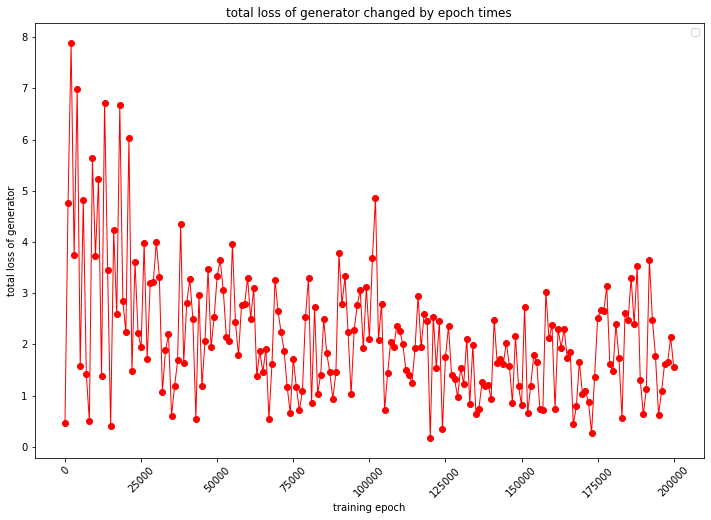

In [17]:
plt.figure(figsize = (12,8))
epochtime = np.arange(0,201000,1000)
plt.plot(epochtime,g_total_loss_list,color='red',marker='o',linestyle='-',linewidth=1)
plt.xlabel('training epoch')
plt.xticks(rotation=45) # 旋转90度
plt.ylabel('total loss of generator')
plt.title('total loss of generator changed by epoch times')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


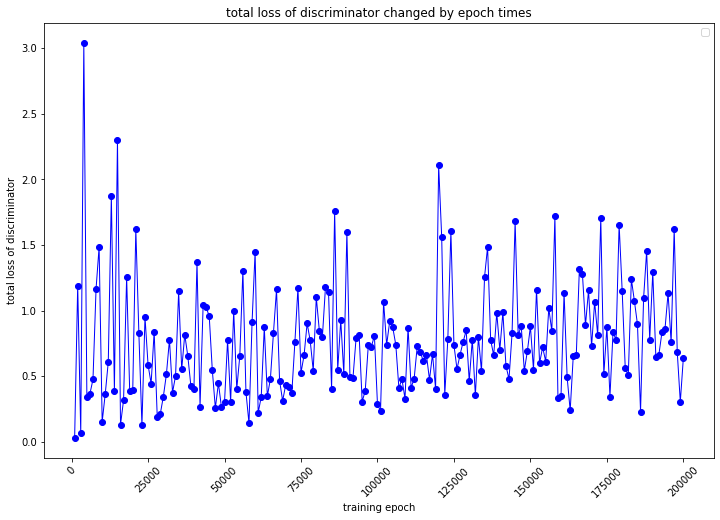

In [18]:
plt.figure(figsize = (12,8))
epochtime = np.arange(1000,201000,1000)
plt.plot(epochtime,d_total_loss_list[1:],color='blue',marker='o',linestyle='-',linewidth=1)
plt.xlabel('training epoch')
plt.xticks(rotation=45) # 旋转90度
plt.ylabel('total loss of discriminator')
plt.title('total loss of discriminator changed by epoch times')
plt.legend()
plt.show()

In [19]:
print("mean of total loss of generator: {:.6f}".format(np.mean(g_total_loss_list)))
print("mean of total loss of discriminator: {:.6f}".format(np.mean(d_total_loss_list)))

mean of total loss of generator: 2.164618
mean of total loss of discriminator: 0.803438


In [20]:
# 定义参数
batch_size = 1  # 每次测试的批次（太大可能会显存不够而报错，可调小再试）
fake_num = 500  # 生成的图片的个数
dataset_name = 'female'  # 数据集的名字  star_imgs
h, w, c = 256, 256, 3  # 数据集图片的宽和高，也是生成图片的宽和高
noise_dim = 100  # 输入噪声的维度（一般不改）

In [21]:
# 创建文件夹
directory = './checkpoint3/' + dataset_name + '_%s×%s' % (h, w)  # 输出参数保存的文件夹，一般不改
image_dir = './result_image3/' + dataset_name + '_%s×%s' % (h, w)  # 输出图片保存的文件夹，一般不改

In [22]:
# 搭建网络
generator = generator_network_dcgan(h, w, c, noise_dim=noise_dim)
discriminator = discriminator_network_dcgan(h, w, c)
# 加载参数
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator)
checkpoint.restore(tf.train.latest_checkpoint(directory))  # 断点续训
# 预测
# noise_test = tf.random.normal([fake_num, 100])
noise_test = tf.random.uniform([fake_num, noise_dim], -1, 1)
fake_images = generator.predict(noise_test, batch_size=batch_size)  # (b,h,w,c)
fake_images = (fake_images.reshape(-1, h, w, c) * 127.5 + 127.5).astype('uint8')  # (b,h,w,c)

In [23]:
# 保存生成的图片
os.makedirs('test_from_dir3', exist_ok=True)
for i, fake_image in enumerate(fake_images):
    # i+=5000
    save_path = os.path.join('test_from_dir3', '%s.png' % (i + 1))
    cv.imwrite(save_path, fake_image)
    print('输出的单张图片已保存到：%s' % save_path)

输出的单张图片已保存到：test_from_dir3/1.png
输出的单张图片已保存到：test_from_dir3/2.png
输出的单张图片已保存到：test_from_dir3/3.png
输出的单张图片已保存到：test_from_dir3/4.png
输出的单张图片已保存到：test_from_dir3/5.png
输出的单张图片已保存到：test_from_dir3/6.png
输出的单张图片已保存到：test_from_dir3/7.png
输出的单张图片已保存到：test_from_dir3/8.png
输出的单张图片已保存到：test_from_dir3/9.png
输出的单张图片已保存到：test_from_dir3/10.png
输出的单张图片已保存到：test_from_dir3/11.png
输出的单张图片已保存到：test_from_dir3/12.png
输出的单张图片已保存到：test_from_dir3/13.png
输出的单张图片已保存到：test_from_dir3/14.png
输出的单张图片已保存到：test_from_dir3/15.png
输出的单张图片已保存到：test_from_dir3/16.png
输出的单张图片已保存到：test_from_dir3/17.png
输出的单张图片已保存到：test_from_dir3/18.png
输出的单张图片已保存到：test_from_dir3/19.png
输出的单张图片已保存到：test_from_dir3/20.png
输出的单张图片已保存到：test_from_dir3/21.png
输出的单张图片已保存到：test_from_dir3/22.png
输出的单张图片已保存到：test_from_dir3/23.png
输出的单张图片已保存到：test_from_dir3/24.png
输出的单张图片已保存到：test_from_dir3/25.png
输出的单张图片已保存到：test_from_dir3/26.png
输出的单张图片已保存到：test_from_dir3/27.png
输出的单张图片已保存到：test_from_dir3/28.png
输出的单张图片已保存到：test_from_dir3/29.png
输出的单张图片已保存到：test_from_d

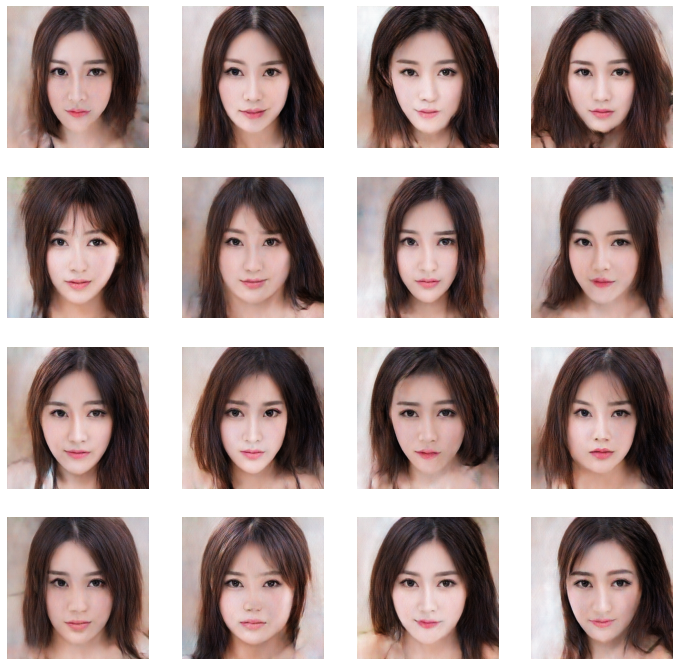

In [24]:
# 查看部分生成图片
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    if c == 3:
        fake_images[i] = cv.cvtColor(fake_images[i], cv.COLOR_BGR2RGB)
    plt.imshow(fake_images[i])
    plt.axis('off')
plt.show()